In [1]:
import numpy as np
import pandas as pd
import xgboost as xg

#### Sklearn #####
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
#from pandas_profiling import ProfileReport
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot
import datetime
from scipy.stats import uniform, truncnorm, randint
from xgboost import plot_importance
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

import pickle
%cd "C:\\Users\\jwr17\\Box Sync\\Project 1 FreshAir Veena, Eric K., Mukta, Josh\\DF's for sample 8368"


C:\Users\jwr17\Box Sync\Project 1 FreshAir Veena, Eric K., Mukta, Josh\DF's for sample 8368


In [2]:
names=[word.replace('.csv','') for word in os.listdir()]
df={}

for i, file in enumerate(os.listdir()):
    df[names[i]]=pd.read_csv(file)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [18]:
df.keys()

dict_keys(['corr_and_rec_level', 'diff_dur_infl', 'FA_FeatureEngineering_RH_TP_CO_chnage_std_log_gradient_8368', 'master_df_of_8368', 'master_roberge_jan13', 'sample_of_8368', 'xg_td_1'])

In [22]:
###### merging dfs together ######

master=pd.merge(df[os.listdir()[0][:-4]],df[os.listdir()[1][:-4]], how='inner', on=['id','timestamp','device_id'])
master=pd.merge(master,df[os.listdir()[4][:-4]], how='inner', on=['id','timestamp','device_id'])

### cleaning Up df #######
master=master.replace([np.inf, -np.inf], np.nan) #### there are a few infintie values which will get in the way converting to NaN's to drop
master=master.dropna() ### droping nas

######### seperating responce and explainatory and dropiing keys
responce=master.review_label
explanantory=master.drop(columns=['review_label','alert_id','id','timestamp','device_id','Unnamed: 0_y','Unnamed: 0','Unnamed: 0_x'])


### re-binning responce variable ####
new_y={
    1:'Smoking induced',
    2:'Smoking induced',
    3:'Smoking induced',
    10:'Inconclusive',
    11:'Inconclusive',
    13:'Inconclusive',
    20:'Environmental Anomalies',
    30:'Environmental Anomalies',
    31:'Environmental Anomalies',
    32:'Environmental Anomalies',
    33:'Environmental Anomalies',
    34:'Environmental Anomalies',
    35:'Environmental Anomalies',
    36:'Environmental Anomalies',
    45:'Environmental Anomalies',
    50:'Environmental Anomalies',  
}

responce_cat=responce.map(new_y)


##### changing the string of duration to total number of seconds #######
explanantory.S1_Dur=[secs.total_seconds() for secs in pd.to_timedelta(explanantory.S1_Dur)]
explanantory.S2_Dur=[secs.total_seconds() for secs in pd.to_timedelta(explanantory.S2_Dur)]
explanantory.CO_Dur=[secs.total_seconds() for secs in pd.to_timedelta(explanantory.CO_Dur)]


,Unnamed: 0_x,R_CO2,R_CO4,R_RH2,R_RH4,R_TP2,R_TP4,RH_TP2,RH_TP4,CO_RH_S,...,S1_longest_strike_below_mean,S2_longest_strike_below_mean,TP_longest_strike_below_mean,CO_baseline,RH_baseline,S1_baseline,S2_baseline,TP_baseline,review_label,alert_id
0,0,0.952400,0.957783,0.308014,0.325269,-0.080619,-0.122617,-0.745545,-0.752259,0.937001,...,297.0,299.0,112.0,6717.086334,5624.700759,9.004193e+04,1.074834e+05,2736.608292,2,1486194.0
1,1,0.965796,0.962934,0.606007,0.576394,0.464804,0.438891,0.953644,0.956727,0.974522,...,209.0,210.0,213.0,6738.748914,3668.698328,1.612581e+05,1.586169e+05,2762.778046,2,1486290.0
2,2,0.839827,0.853810,0.705931,0.726156,0.004919,-0.021793,-0.460017,-0.468898,0.835029,...,292.0,296.0,185.0,6697.546973,3658.177590,2.613995e+04,6.444468e+04,3229.229697,1,1486303.0
3,3,0.373094,0.343624,-0.713610,-0.706864,-0.771036,-0.763554,0.947290,0.947130,0.785371,...,137.0,130.0,110.0,6554.747246,4184.189689,8.211375e+05,1.497737e+06,2680.139558,2,1486391.0
4,4,0.885375,0.893802,0.410414,0.422503,0.276294,0.251009,0.360242,0.365105,0.784554,...,136.0,172.0,299.0,6571.348992,4392.513563,8.416378e+04,1.124339e+05,2767.372336,2,1486489.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8363,8363,0.900458,0.911318,-0.764024,-0.763187,-0.812312,-0.803865,0.913067,0.920996,0.812280,...,202.0,200.0,139.0,6562.257984,4121.358121,1.756933e+05,5.921404e+05,2618.376516,10,1606952.0
8364,8364,0.611390,0.611635,0.827828,0.826450,-0.432334,-0.431188,-0.843628,-0.845265,0.736757,...,64.0,67.0,71.0,6581.985412,3394.714461,2.417098e+06,5.494338e+05,2815.056746,10,1606949.0
8365,8365,-0.035331,-0.033920,-0.863407,-0.865078,-0.129356,-0.131908,0.195827,0.219258,0.185739,...,59.0,53.0,29.0,6601.419924,4826.471934,8.940296e+05,1.256976e+05,2122.816898,30,1606971.0
8366,8366,-0.596613,-0.662228,0.954344,0.959920,-0.935697,-0.939875,-0.985142,-0.985580,0.489467,...,198.0,196.0,98.0,6600.494462,3073.166325,3.285181e+06,1.091129e+06,2202.040756,30,1607006.0


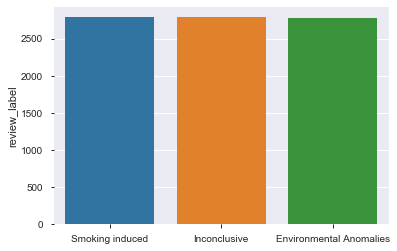

In [24]:
###### equal distribution using stratified smapling #######
responce_cat.value_counts()
sns.barplot(responce_cat.value_counts().index,responce_cat.value_counts())

In [12]:
%cd "C:\Users\jwr17\OneDrive - University of New Hampshire\freshair"
full_dataset=pd.read_csv('master_df_2_20_2020.csv')
full_dataset=full_dataset[full_dataset.y != 'inconclusive']#### inconclusive drop
full_dataset=full_dataset.replace([np.inf, -np.inf], 0)
full_dataset=full_dataset.dropna()
full_dataset=full_dataset.drop(columns=['Unnamed: 0'])
responce_cat=full_dataset.iloc[:,-1]
explanantory=full_dataset.iloc[:,:-5]

C:\Users\jwr17\OneDrive - University of New Hampshire\freshair


In [13]:
full_dataset.apply(lambda x: x == -np.inf).sum().sort_values()


CO_mean                 0
RHbeyond_r_sigma_0.1    0
RHbeyond_r_sigma_0.4    0
RHbeyond_r_sigma_0.6    0
RHbeyond_r_sigma_0.8    0
                       ..
S_CO_3rd_10             0
S_RH                    0
S_RH_1st_10             0
RH_magnitude            0
y                       0
Length: 237, dtype: int64

array(['dismissed', 'clear_smoking'], dtype=object)

In [14]:
#### train test split ####

x_train, x_tes, y_train, y_test= train_test_split(explanantory,responce_cat, test_size=.1)


In [15]:
##### standardizing DF ####
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_tes=scaler.transform(x_tes)


In [17]:
%cd "C:\Users\jwr17\Desktop\Fresh Air git\Fresh_Air\Fresh_Air\models"

xg_params={
    'learning_rate':uniform(.001,.1),
    'n_estimators':randint(50,500),
    'subsample':uniform(.1,.8),
    'max_depth':randint(5,9),
    'lambda ':[1,1.5,2]
}


clf=RandomizedSearchCV(xg.XGBRFClassifier(tree_method='gpu_hist'), 
                       param_distributions=xg_params, n_iter=300, cv=10, verbose=10)

new_models=clf.fit(x_train, y_train)
results=pd.DataFrame(new_models.cv_results_)
results.to_csv('roberge_xg_rd_3.csv')

%cd "C:\Users\jwr17\Desktop\Fresh Air git\Fresh_Air\Fresh_Air\models"

pred_y=new_models.predict(x_tes)

print(classification_report(y_test,pred_y))
display(pd.crosstab(y_test, pred_y, rownames=['Actual'], colnames=['Predicted']))

filename = 'xg_boost_roberge_acur_2'+str(new_models.best_score_)+'.pkl'
pickle.dump(new_models, open(filename, 'wb'))




C:\Users\jwr17\Desktop\Fresh Air git\Fresh_Air\Fresh_Air\models
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.928, total=   5.4s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.938, total=   5.0s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.974, total=   5.1s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.940, total=   5.0s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.4s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.946, total=   5.1s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.6s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.934, total=   5.2s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   30.9s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.952, total=   5.1s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.0s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.962, total=   5.0s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.0s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.926, total=   5.2s
[CV] lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   46.2s remaining:    0.0s


[CV]  lambda =1.5, learning_rate=0.00292558876805774, max_depth=5, n_estimators=310, subsample=0.7177083312181777, score=0.944, total=   5.1s
[CV] lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.8590678998301662 
[CV]  lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.8590678998301662, score=0.936, total=  25.1s
[CV] lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.8590678998301662 
[CV]  lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.8590678998301662, score=0.942, total=  25.3s
[CV] lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.8590678998301662 
[CV]  lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.8590678998301662, score=0.972, total=  26.0s
[CV] lambda =2, learning_rate=0.06607485891744434, max_depth=8, n_estimators=442, subsample=0.85906789

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 404.9min finished


C:\Users\jwr17\Desktop\Fresh Air git\Fresh_Air\Fresh_Air\models
               precision    recall  f1-score   support

clear_smoking       0.95      0.95      0.95       274
    dismissed       0.95      0.95      0.95       285

     accuracy                           0.95       559
    macro avg       0.95      0.95      0.95       559
 weighted avg       0.95      0.95      0.95       559



Predicted,clear_smoking,dismissed
Actual,,
clear_smoking,261,13
dismissed,14,271


In [18]:
%cd "C:\Users\jwr17\Desktop\Fresh Air git\Fresh_Air\Fresh_Air\models"

pred_y=new_models.predict(x_tes)

print(classification_report(y_test,pred_y))
display(pd.crosstab(y_test, pred_y, rownames=['Actual'], colnames=['Predicted']))

filename = 'xg_boost_roberge_acur_'+str(new_models.best_score_)+'.pkl'
pickle.dump(new_models, open(filename, 'wb'))






%cd "C:\Users\jwr17\OneDrive - University of New Hampshire\freshair"


test_df=pd.read_csv('anomlies-1910-testdf.csv')
test_df=test_df.drop(columns=['Unnamed: 0'])
scaler = StandardScaler()

test_df=test_df.replace([np.inf, -np.inf], np.nan)
test_df=test_df.dropna()

x=test_df.iloc[:,:-5]
y=test_df.y
x = scaler.fit_transform(x)


predicted=new_models.predict(x)
print(classification_report(y,predicted))

C:\Users\jwr17\Desktop\Fresh Air git\Fresh_Air\Fresh_Air\models
               precision    recall  f1-score   support

clear_smoking       0.95      0.95      0.95       274
    dismissed       0.95      0.95      0.95       285

     accuracy                           0.95       559
    macro avg       0.95      0.95      0.95       559
 weighted avg       0.95      0.95      0.95       559



Predicted,clear_smoking,dismissed
Actual,,
clear_smoking,261,13
dismissed,14,271


C:\Users\jwr17\OneDrive - University of New Hampshire\freshair


NameError: name 'x' is not defined

In [7]:
new_models.best_score_

0.954608035519613

In [52]:
#test_df=test_df.drop(columns=['Unnamed: 0'])



%cd "C:\Users\jwr17\OneDrive - University of New Hampshire\freshair"


test_df=pd.read_csv('anomlies-1910-testdf.csv')
test_df=test_df.drop(columns=['Unnamed: 0'])
test_df=test_df[test_df.y != 'inconclusive']
scaler = StandardScaler()

test_df=test_df.replace([np.inf, -np.inf], np.nan)
test_df=test_df.dropna()

x=test_df.iloc[:,:-5]
y=test_df.y
x = scaler.fit_transform(x)


predicted=new_models.predict(x)
print(classification_report(y,predicted))

C:\Users\jwr17\OneDrive - University of New Hampshire\freshair
               precision    recall  f1-score   support

clear_smoking       0.28      0.99      0.44      1064
    dismissed       1.00      0.74      0.85     10138

     accuracy                           0.76     11202
    macro avg       0.64      0.86      0.64     11202
 weighted avg       0.93      0.76      0.81     11202



In [51]:
test_df[test_df.y != 'inconclusive']

,CO_mean,RH_mean,TP_mean,S_mean,CO_amin,RH_amin,TP_amin,S_amin,CO_amax,RH_amax,...,TP_lag_2,S_lag_3,CO_lag_3,RH_lag_3,TP_lag_3,device_id,id,timestamp,review_label,y
0,6842.268983,4169.768626,2572.961915,3.122835e+06,6776.747392,3931.350217,2516.643748,3.083152e+06,6898.042803,4473.699995,...,2573.013054,3.122703e+06,6842.139992,4170.693492,2573.032038,119220402,58366,2019-10-31 23:59:36,30,dismissed
1,6010.315363,6140.376041,2295.123608,4.698697e+05,5785.549909,5685.999996,2210.000000,4.572246e+05,6089.000025,6314.944219,...,2295.257507,4.697985e+05,6011.291145,6140.744937,2295.328336,118480027,58365,2019-10-31 23:59:05,30,dismissed
3,6539.605384,5525.457523,2427.543684,8.448359e+05,6526.999925,5134.000032,2360.635487,5.486377e+05,6558.550222,5796.000094,...,2427.140038,8.407960e+05,6539.524178,5527.623420,2426.944147,118180002,58363,2019-10-31 23:57:16,30,dismissed
5,6419.612826,6761.228693,2300.914022,1.569522e+06,6007.406989,6263.000000,2275.290112,1.550802e+06,7006.999859,6894.025930,...,2300.927218,1.569391e+06,6419.280765,6763.712113,2300.920554,119150237,58361,2019-10-31 23:56:17,30,dismissed
6,6537.448029,1996.535533,2369.844478,2.577912e+06,6518.493796,1955.542639,2308.908758,2.529984e+06,6588.597782,2322.999986,...,2370.073050,2.577928e+06,6537.225711,1994.839270,2370.175748,119290388,58360,2019-10-31 23:56:14,30,dismissed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13357,6550.765602,6070.987702,2335.439180,1.593410e+06,6530.190178,5242.000000,2297.000350,1.486726e+06,6593.742041,6859.206592,...,2335.529697,1.592950e+06,6550.621386,6072.211653,2335.574605,119210074,9,2019-10-01 04:07:09,2,clear_smoking
13358,6647.955798,6198.384588,2475.310812,2.524377e+06,6622.999921,5649.999887,2427.000000,2.458658e+06,6700.182059,6553.999952,...,2474.870235,2.524496e+06,6647.689465,6196.480339,2474.648624,119200200,8,2019-10-01 03:50:48,2,clear_smoking
13359,6542.268233,5949.882695,2326.579782,1.584732e+06,6520.013551,5242.000000,2277.000001,1.486726e+06,6593.702694,6859.227957,...,2326.615294,1.584407e+06,6542.085997,5950.215381,2326.632022,119210074,7,2019-10-01 03:18:16,2,clear_smoking
13360,6660.193009,4378.302356,2236.779136,1.348027e+05,6609.999998,4098.000000,2135.634584,1.233980e+05,6708.663565,4726.000071,...,2236.489204,1.346938e+05,6659.964770,4378.848572,2236.344522,119220105,6,2019-10-01 03:12:20,2,clear_smoking


In [42]:
x=test_df.iloc[:,:-5]
y=test_df.y

x=x.replace([np.inf, -np.inf], np.nan)
x=x.dropna()

,CO_mean,RH_mean,TP_mean,S_mean,CO_amin,RH_amin,TP_amin,S_amin,CO_amax,RH_amax,...,RH_lag,TP_lag,S_lag_2,CO_lag_2,RH_lag_2,TP_lag_2,S_lag_3,CO_lag_3,RH_lag_3,TP_lag_3
0,6842.268983,4169.768626,2572.961915,3.122835e+06,6776.747392,3931.350217,2516.643748,3.083152e+06,6898.042803,4473.699995,...,4170.064117,2572.989685,3.122744e+06,6842.180959,4170.372381,2573.013054,3.122703e+06,6842.139992,4170.693492,2573.032038
1,6010.315363,6140.376041,2295.123608,4.698697e+05,5785.549909,5685.999996,2210.000000,4.572246e+05,6089.000025,6314.944219,...,6140.492840,2295.189313,4.698237e+05,6010.962610,6140.615836,2295.257507,4.697985e+05,6011.291145,6140.744937,2295.328336
3,6539.605384,5525.457523,2427.543684,8.448359e+05,6526.999925,5134.000032,2360.635487,5.486377e+05,6558.550222,5796.000094,...,5526.145001,2427.339866,8.421323e+05,6539.544137,5526.862060,2427.140038,8.407960e+05,6539.524178,5527.623420,2426.944147
4,6684.992560,4420.435466,2240.490556,4.646556e+06,6660.011712,4113.675626,2120.833898,4.618726e+06,6765.847188,4492.256551,...,4420.603832,2240.475948,4.646262e+06,6684.687117,4420.769686,2240.463302,4.646114e+06,6684.548108,4420.934189,2240.452508
5,6419.612826,6761.228693,2300.914022,1.569522e+06,6007.406989,6263.000000,2275.290112,1.550802e+06,7006.999859,6894.025930,...,6762.077832,2300.925104,1.569431e+06,6419.426572,6762.900656,2300.927218,1.569391e+06,6419.280765,6763.712113,2300.920554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13357,6550.765602,6070.987702,2335.439180,1.593410e+06,6530.190178,5242.000000,2297.000350,1.486726e+06,6593.742041,6859.206592,...,6071.393112,2335.484605,1.593097e+06,6550.667322,6071.801855,2335.529697,1.592950e+06,6550.621386,6072.211653,2335.574605
13358,6647.955798,6198.384588,2475.310812,2.524377e+06,6622.999921,5649.999887,2427.000000,2.458658e+06,6700.182059,6553.999952,...,6197.753090,2475.090804,2.524457e+06,6647.780295,6197.118879,2474.870235,2.524496e+06,6647.689465,6196.480339,2474.648624
13359,6542.268233,5949.882695,2326.579782,1.584732e+06,6520.013551,5242.000000,2277.000001,1.486726e+06,6593.702694,6859.227957,...,5950.026758,2326.597908,1.584514e+06,6542.151685,5950.137450,2326.615294,1.584407e+06,6542.085997,5950.215381,2326.632022
13360,6660.193009,4378.302356,2236.779136,1.348027e+05,6609.999998,4098.000000,2135.634584,1.233980e+05,6708.663565,4726.000071,...,4378.478502,2236.634049,1.347305e+05,6660.043697,4378.660089,2236.489204,1.346938e+05,6659.964770,4378.848572,2236.344522


In [28]:
x_scaleds

array([[-1.73192119,  0.0038859 , -0.50886135, ...,  0.00335004,
        -0.50800454,  0.7287989 ],
       [-1.73166194, -0.64428029,  1.14893929, ..., -0.6423513 ,
         1.14922218, -0.3811905 ],
       [-1.73140269,  2.40377347,  0.53895153, ...,  2.38720603,
         0.53905511,  0.37397218],
       ...,
       [ 1.73140269, -0.22984148,  0.98868414, ..., -0.22983951,
         0.98894684, -0.2560688 ],
       [ 1.73166194, -0.13796755, -0.33342948, ..., -0.13822901,
        -0.33290244, -0.61695044],
       [ 1.73192119, -0.15251776, -0.27796942, ..., -0.15283054,
        -0.27708782, -0.7824218 ]])

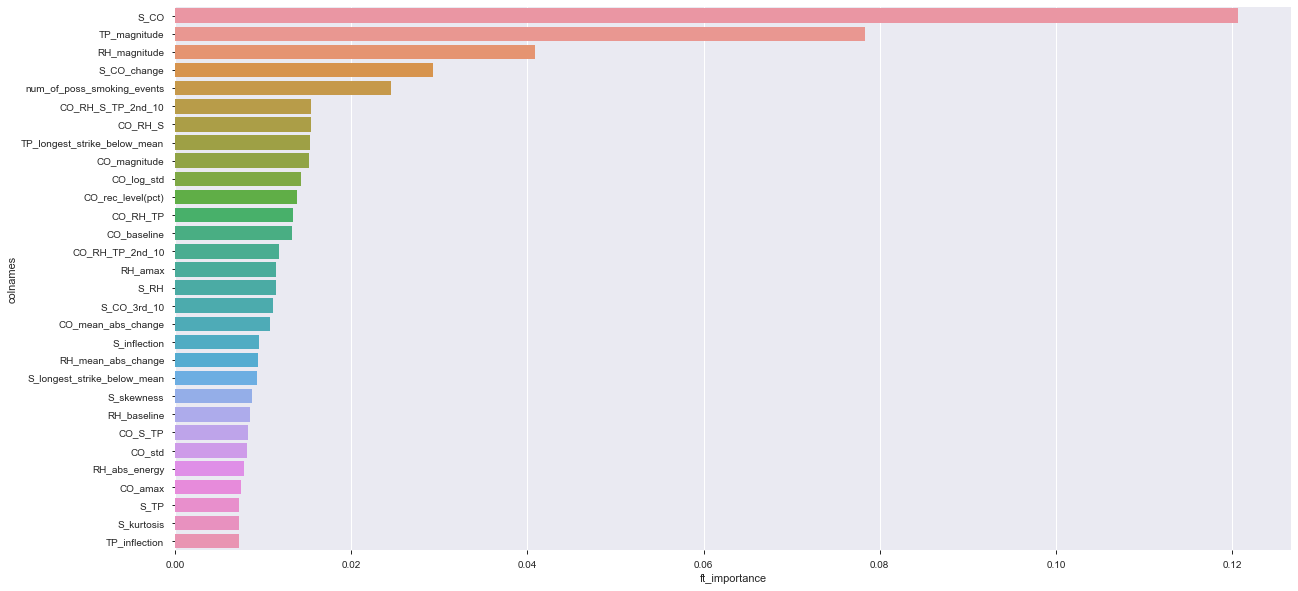

In [59]:
x=pd.DataFrame()
fig, ax = plt.subplots(figsize=(20, 10))
x['ft_importance']=new_models.best_estimator_.feature_importances_
x['colnames']=explanantory.columns

x=x.sort_values('ft_importance', ascending=False).iloc[0:30,:]

sns.barplot(x=x.ft_importance,y=x.colnames, ax=ax)


6500    clear_smoking
7746        dismissed
3639    clear_smoking
6737        dismissed
4192        dismissed
            ...      
7236    clear_smoking
6320        dismissed
2650        dismissed
6960        dismissed
1301        dismissed
Name: y, Length: 559, dtype: object

In [25]:
explanantory.columns

Index(['R_CO2', 'R_CO4', 'R_RH2', 'R_RH4', 'R_TP2', 'R_TP4', 'RH_TP2',
       'RH_TP4', 'CO_RH_S', 'CO_RH_TP',
       ...
       'CO_longest_strike_below_mean', 'RH_longest_strike_below_mean',
       'S1_longest_strike_below_mean', 'S2_longest_strike_below_mean',
       'TP_longest_strike_below_mean', 'CO_baseline', 'RH_baseline',
       'S1_baseline', 'S2_baseline', 'TP_baseline'],
      dtype='object', length=106)

In [30]:
results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,7.413753,0.223500,0.023402,0.000800,0.0223057,8,52,0.515995,"{'learning_rate': 0.022305739746939657, 'max_d...",0.778443,0.788423,0.768463,0.763648,0.777630,0.775323,0.008603,1
80,44.734948,0.788008,0.133811,0.004215,0.046123,8,330,0.460971,"{'learning_rate': 0.04612295334662057, 'max_de...",0.779774,0.788423,0.764471,0.766312,0.774301,0.774657,0.008824,2
1,26.237364,0.268330,0.076208,0.002402,0.0497436,8,175,0.564322,"{'learning_rate': 0.04974362286494807, 'max_de...",0.775782,0.787758,0.763806,0.765646,0.772304,0.773060,0.008540,3
79,62.805700,0.527950,0.189417,0.009135,0.0314439,8,480,0.419738,"{'learning_rate': 0.03144385747388819, 'max_de...",0.772455,0.787758,0.765802,0.768309,0.769640,0.772794,0.007785,4
13,11.202639,0.217576,0.036202,0.000400,0.0653811,8,84,0.46574,"{'learning_rate': 0.06538114644388018, 'max_de...",0.771790,0.787758,0.771790,0.762983,0.769640,0.772794,0.008151,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,7.672385,0.524916,0.042006,0.000628,0.0772463,6,152,0.108486,"{'learning_rate': 0.07724632735988429, 'max_de...",0.756487,0.743180,0.749168,0.737017,0.740346,0.745242,0.006895,96
78,16.327422,0.088968,0.105810,0.000401,0.0225708,5,436,0.829767,"{'learning_rate': 0.02257078976262568, 'max_de...",0.759148,0.747172,0.739188,0.733688,0.743009,0.744443,0.008591,97
48,9.536914,0.095425,0.064405,0.000490,0.0941731,5,271,0.211778,"{'learning_rate': 0.09417305224663138, 'max_de...",0.754491,0.745176,0.741184,0.739680,0.741012,0.744310,0.005413,98
25,14.420880,0.114073,0.098610,0.000801,0.0248276,5,415,0.197419,"{'learning_rate': 0.02482757882515473, 'max_de...",0.758483,0.738523,0.745842,0.734354,0.734354,0.742313,0.009110,99
